fpkm shape: (887, 19962)
deconvo shape: (835, 9853)
tpm shape: (887, 19969)
event.PAM50
LumA     464
LumB     193
Basal    146
Her2      74
Name: count, dtype: int64
Mean Squared Error: 0.035
R^2 Score: 0.647


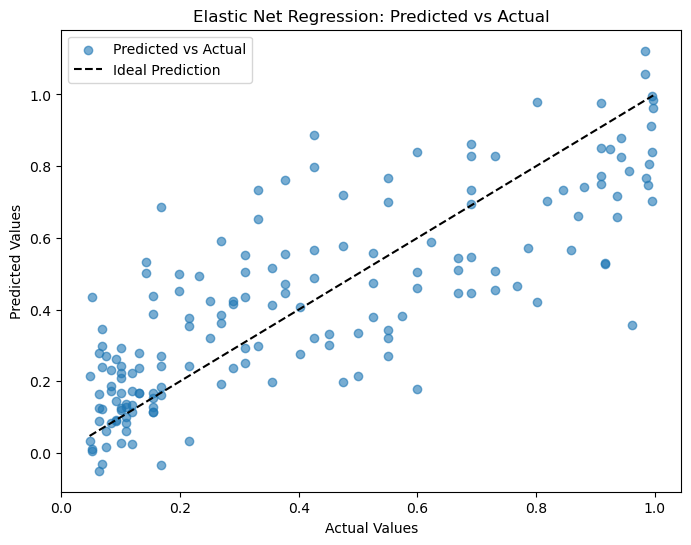

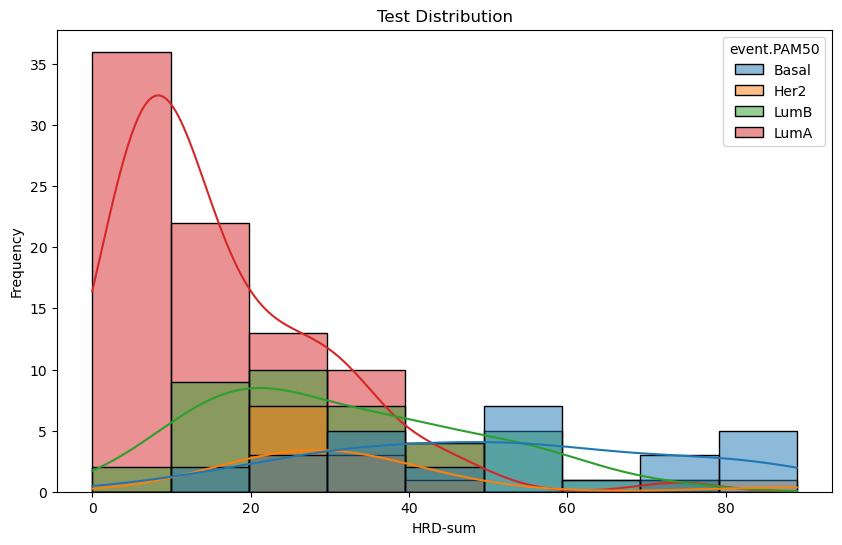

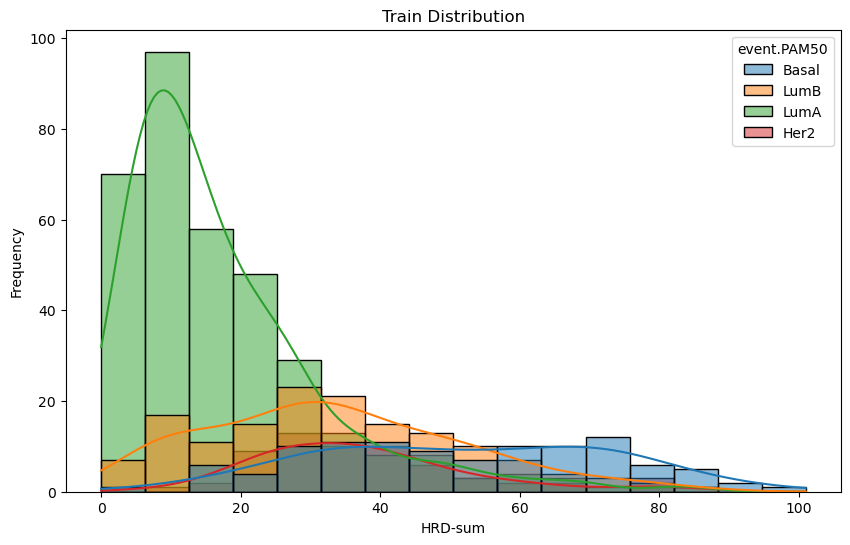

In [18]:
import pandas as pd
from joblib import Parallel, delayed
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# -------------------- Data Loading and Preprocessing --------------------

# Load metadata and HRD scores
ann_tcga = pd.read_csv('../data/toga.breast.brca.status.txt', sep='\t', index_col=0)
hrd_scores = pd.read_excel('../data/tcga.hrdscore.xlsx', index_col=0)

# Load RNAseq data
fpkm = pd.read_csv('../data/tcga.brca.rnaseq.unstranded.fpkm.counts.matrix.txt', sep='\t', index_col=0)
deconvo = pd.read_csv('../data/Deconvo2.csv',  index_col=0)
tpm = pd.read_csv('../data/tpm.csv', index_col=0, low_memory=False)

# Filter metadata
metadata = ann_tcga[~ann_tcga['event.RAD51C'].ne('0')]
metadata = metadata[~metadata['event.PALB2'].ne('0')]
metadata = metadata[metadata['event.BRCA1'] != '1']
metadata.index = metadata.index.str.replace('.', '-', regex=False)
hrd_scores.index = hrd_scores.index.map(lambda x: x[:12])
metadata = metadata.merge(hrd_scores[['HRD-sum']], left_index=True, right_index=True, how='inner')

# Process fpkm data
fpkm = fpkm.set_index('Case ID')
fpkm = fpkm[fpkm['Sample Type'] == 'Primary Tumor']
fpkm = fpkm.drop(columns=["Sample ID","Sample Type"])

# Rename columns using a dictionary constructed from fpkm columns
dick = {}
for i, v in enumerate(fpkm.columns):
    parts = v.split('|')
    if len(parts) > 1:
        dick[parts[0]] = parts[1]
tpm = tpm.rename(columns=dick)
tpm = tpm[~tpm.index.duplicated(keep='first')]

# Keep only Primary Tumor samples in tpm
tpm = tpm.loc[tpm.index.str[13:15] == "01"]

filtered_columns = [col for col in fpkm.columns if '|' in col and 'protein_coding' in col.split('|')[2]]
fpkm = fpkm[filtered_columns]

# Further processing for fpkm
fpkm.columns = [col.split('|')[1] if '|' in col else col for col in fpkm.columns]
fpkm.index = fpkm.index.map(lambda x: x[:12])
fpkm = fpkm.loc[fpkm.index.intersection(metadata.index)]
fpkm.sort_index(inplace=True)
fpkm = fpkm.rename_axis("fpkm", axis="index")
fpkm = fpkm.apply(pd.to_numeric, errors='coerce')
fpkm.fillna(0, inplace=True)

# Process deconvo
deconvo.index = deconvo.index.map(lambda x: x[:12])
deconvo = deconvo.loc[deconvo.index.intersection(metadata.index)]
deconvo.sort_index(inplace=True)
deconvo = deconvo.rename_axis("deconvo", axis="index")
deconvo.fillna(0, inplace=True)

# Process tpm
tpm.index = tpm.index.map(lambda x: x[:12])
tpm = tpm.loc[tpm.index.intersection(metadata.index)]
tpm.sort_index(inplace=True)
tpm = tpm.rename_axis("tpm", axis="index")
tpm = tpm.apply(pd.to_numeric, errors='coerce')
tpm.fillna(0, inplace=True)
tpm = tpm[tpm.columns.intersection(fpkm.columns)]


print(f"fpkm shape: {fpkm.shape}")
print(f"deconvo shape: {deconvo.shape}")
print(f"tpm shape: {tpm.shape}")

# Display counts for PAM50 subtypes
pam50_counts = metadata['event.PAM50'].value_counts()
print(pam50_counts)

# -------------------- Helper Functions --------------------

def downsampling_lumA(metadata, lumA_cutoff):
    """Downsamples LumA samples to match HRD count."""
    lumA_HRD = metadata[(metadata['event.PAM50'] == 'LumA') & (metadata['HRD-sum'] >= lumA_cutoff)]
    lumA_HRP = metadata[(metadata['event.PAM50'] == 'LumA') & (metadata['HRD-sum'] < lumA_cutoff)]
    if lumA_HRP.shape[0] < lumA_HRD.shape[0]:
        return metadata, pd.DataFrame()
    lumA_HRP_downsampled = lumA_HRP.sample(n=lumA_HRD.shape[0], random_state=42)
    df_downsampled = pd.concat([lumA_HRD, lumA_HRP_downsampled])
    df_downsampled = pd.concat([df_downsampled, metadata[metadata['event.PAM50'] != 'LumA']])
    unused_majority = lumA_HRP.loc[~lumA_HRP.index.isin(lumA_HRP_downsampled.index)]
    return df_downsampled, unused_majority

def add_back_test(rna_df, removed_samples, X_test, y_test):
    """Adds back removed samples to the test set if required."""
    add_back_features = rna_df.loc[rna_df.index.intersection(removed_samples.index)]
    add_back_features = add_back_features.sort_index()
    add_back_y = removed_samples.loc[removed_samples.index.intersection(rna_df.index)]
    add_back_y = add_back_y.sort_index()
    X_test = pd.concat([X_test, add_back_features])
    y_test = pd.concat([y_test, add_back_y['HRD-sum'].squeeze()])
    return X_test, y_test

def sigmoid_transform(values, shift=0, scale=1):
    """Apply sigmoid transformation to a series of values."""
    return 1 / (1 + np.exp(-scale * (values - shift)))

def binary_hrd(values, threshold):
    """Convert continuous HRD values into binary classes based on a threshold."""
    return (values >= threshold).astype(int)

def plot_test_train_pam50_dist(metadata, X_train, X_test):
    """Plot HRD-sum distributions for training and test samples, colored by PAM50 subtype."""
    plt.figure(figsize=(10, 6))
    sns.histplot(data=metadata.loc[metadata.index.intersection(X_test.index)],
                 x='HRD-sum', hue='event.PAM50', multiple='layer', kde=True)
    plt.title('Test Distribution')
    plt.xlabel('HRD-sum')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.histplot(data=metadata.loc[metadata.index.intersection(X_train.index)],
                 x='HRD-sum', hue='event.PAM50', multiple='layer', kde=True)
    plt.title('Train Distribution')
    plt.xlabel('HRD-sum')
    plt.ylabel('Frequency')
    plt.show()

features_df = deconvo
metadata_truncated = metadata.loc[metadata.index.intersection(features_df.index)]
# Add a base HRD status (not used in the final regression but for DESeq2 design)
metadata_truncated['HRD_status_base'] = metadata_truncated['HRD-sum'].apply(lambda x: 'HRD' if x >= 42 else 'HR')
softLabel_metadata = metadata_truncated.sort_index()

features_df = features_df.fillna(0).astype(int)
features_df = features_df[sorted(features_df.columns)]
gene_expression_int = features_df.sort_index()

# -------------------- Model Training Function --------------------
common_de_genes = []
def train_model(params, metadata):
    global common_de_genes
    # Subset the expression data to only include DE genes
    labels_df = metadata_truncated['HRD-sum'].sort_index()
    features_df = gene_expression_int
    features_df = features_df.sort_index()
    
    # Normalize features if requested
    if params['normalization'] == 'StandardScaler':
        scaler = StandardScaler()
        features_df = pd.DataFrame(scaler.fit_transform(features_df), index=features_df.index, columns=features_df.columns)
    elif params['normalization'] == 'log2':
        features_df = np.log2(features_df + 1)
    
    # Apply soft labeling
    if params['softlabels'] == "Sigmoid":
        labels_df = sigmoid_transform(labels_df, params['softlabel_thresholds'], params['softlabel_gradients'])
    elif params['softlabels'] == "Binary":
        labels_df = binary_hrd(labels_df, params['softlabel_thresholds'])
    
    # Optionally downsample LumA samples (here, we are not downsampling because fixed params indicate False)
    removed_samples = None
    if params['downsample'][0]:
        df_downsampled, removed_samples = downsampling_lumA(metadata_truncated, params['downsample_thresholds'])
        features_df = features_df.loc[features_df.index.intersection(df_downsampled.index)]
        labels_df = df_downsampled.loc[df_downsampled.index.intersection(features_df.index), 'HRD-sum']
    
    labels = labels_df.squeeze()
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features_df, labels, test_size=0.2, random_state=42)
    
    # Optionally add back removed samples to test set if required
    if params['downsample'][1] and removed_samples is not None:
        X_test, y_test = add_back_test(features_df, removed_samples, X_test, y_test)
    
    # Train the ElasticNet model
    warnings.filterwarnings("ignore")
    model = ElasticNet(alpha=params['alpha'], l1_ratio=params['l1_ratio'], max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    
    # Predict and evaluate on the test set
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    common_de_genes = features_df.columns
    
    return mse, r2, model, X_train, X_test, y_test, y_pred

# -------------------- Run with Fixed Parameters --------------------

# Use the fixed parameters as specified
fixed_params = {
    'softlabels': 'Sigmoid', 
    'softlabel_thresholds': 30, 
    'softlabel_gradients': 0.1, 
    'normalization': 'log2', 
    'l1_ratio': 0.5, 
    'downsample_thresholds': 35, 
    'downsample': (False, False), 
    'alpha': 0.01
}

# Train the model with the fixed parameters
mse, r2, model, X_train, X_test, y_test, y_pred = train_model(fixed_params, metadata)

print(f"Mean Squared Error: {mse:.3f}")
print(f"R^2 Score: {r2:.3f}")

# Save the trained model if desired
joblib.dump(model, 'best_model.joblib')

# -------------------- Plotting --------------------

# Plot Predicted vs. Actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, label='Predicted vs Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label='Ideal Prediction')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Elastic Net Regression: Predicted vs Actual')
plt.legend(loc="upper left")
plt.show()

# Optionally, plot the training and test distribution of HRD-sum (colored by PAM50 subtype)
plot_test_train_pam50_dist(metadata_truncated, X_train, X_test)


In [19]:
len(common_de_genes)


9853

In [20]:
[print(n) for n in common_de_genes if n[0]=='B']

B2M
B3GALNT1
B3GALNT2
B3GALT4
B3GALT6
B3GAT3
B3GNT2
B3GNT5
B3GNT7
B3GNT8
B3GNT9
B3GNTL1
B4GALNT3
B4GALNT4
B4GALT1
B4GALT2
B4GALT3
B4GALT4
B4GALT5
B4GALT7
B4GAT1
B9D1
B9D2
BAALC
BABAM1
BACE1
BACE2
BACH1
BAD
BAG1
BAG2
BAG3
BAG4
BAG5
BAG6
BAHCC1
BAHD1
BAIAP2
BAIAP2L1
BAK1
BAMBI
BANF1
BANP
BAP1
BARD1
BARX2
BASP1
BATF
BAX
BAZ1A
BAZ1B
BAZ2A
BAZ2B
BBC3
BBIP1
BBOX1
BBS10
BBS2
BBS4
BBS7
BBS9
BBX
BCAM
BCAP29
BCAR1
BCAR3
BCAS1
BCAS2
BCAS3
BCAS4
BCAT2
BCCIP
BCDIN3D
BCKDHA
BCKDHB
BCKDK
BCL10
BCL11A
BCL2
BCL2A1
BCL2L1
BCL2L11
BCL2L12
BCL2L13
BCL2L2
BCL3
BCL6
BCL7A
BCL7B
BCL7C
BCL9
BCL9L
BCLAF1
BCR
BCS1L
BDH1
BDH2
BDP1
BECN1
BEND5
BEST1
BET1
BET1L
BFAR
BHLHE40
BHLHE41
BICD1
BICD2
BID
BIK
BIN1
BIN3
BIRC2
BIRC3
BIRC5
BIRC6
BIVM
BLCAP
BLMH
BLNK
BLOC1S1
BLOC1S2
BLOC1S3
BLOC1S4
BLOC1S6
BLVRA
BLVRB
BLZF1
BMF
BMI1
BMP2K
BMP7
BMPR1A
BMPR2
BMS1
BNIP1
BNIP2
BNIP3
BNIP3L
BNIPL
BOC
BOD1
BOD1L1
BOK
BOLA1
BOLA2B
BOLA3
BOP1
BPGM
BPHL
BPI
BPNT1
BPTF
BRAF
BRAP
BRAT1
BRCA1
BRCA2
BRD1
BRD2
BRD3
BRD4
BRD7
BRD8
BRD9
BRF1

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [21]:
import pandas as pd
import numpy as np
import plotly.express as px
from scipy.stats import ttest_ind, mannwhitneyu, pearsonr
from sklearn.preprocessing import StandardScaler

# -------------------------
# 1. Load and Preprocess Expression Data
# -------------------------
ispy2_expr = pd.read_csv(
    '../data/validation/GSE173839_ISPY2_AgilentGeneExp_durvaPlusCtr_FFPE_meanCol_geneLevel_n105.txt',
    sep='\t'
)
ispy2_expr.set_index('GeneName', inplace=True)
ispy2_expr_transposed = ispy2_expr.T
ispy2_expr_transposed.sort_index(inplace=True)

df_filtered = ispy2_expr_transposed.loc[:, ispy2_expr_transposed.columns.intersection(common_de_genes)]

# Identify missing genes that need to be added
missing_genes = set(common_de_genes) - set(df_filtered.columns)

# Add missing columns with 0s
for gene in missing_genes:
    df_filtered[gene] = 0

# Reorder columns to match top_genes_de
df_filtered = df_filtered[common_de_genes]
validation_subset =df_filtered
validation_subset.fillna(0, inplace=True)
validation_subset


,A1BG,A2M,A4GALT,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,AAR2,...,ZSWIM8,ZW10,ZWILCH,ZWINT,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
102596,12.140,8.231,11.98,9.096,8.422,8.448,8.729,8.926,7.726,9.492,...,8.148,7.068,6.504,8.790,7.767,6.736,6.802,9.972,6.729,8.668
111922,11.580,9.978,11.59,8.877,9.412,9.173,8.781,8.692,7.713,8.929,...,9.097,6.992,6.825,7.839,6.948,5.600,6.732,11.000,5.960,8.396
115724,10.820,10.390,12.51,8.672,7.248,8.880,8.488,9.297,7.894,9.028,...,8.764,5.182,6.414,9.675,6.591,5.028,6.132,11.350,6.755,8.488
123591,11.110,8.214,11.54,8.750,8.120,8.967,8.606,8.027,8.277,9.049,...,7.858,6.702,6.451,8.668,7.118,6.971,7.059,11.040,6.993,9.364
134956,10.950,9.422,11.42,9.951,8.430,9.820,8.223,8.964,7.857,9.050,...,8.386,6.594,6.926,8.845,7.211,6.153,6.733,10.560,7.423,8.058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944184,13.450,9.795,10.56,9.553,7.942,9.984,8.386,10.150,8.277,10.240,...,7.996,5.947,6.610,9.070,7.984,5.320,6.649,10.420,7.225,8.538
965961,9.102,9.082,10.66,8.908,7.646,9.535,8.666,9.316,7.621,8.908,...,8.580,6.190,6.837,8.579,7.064,5.536,7.080,11.000,6.860,8.144
979809,10.190,10.630,11.45,9.145,7.950,9.084,9.053,9.673,8.313,9.891,...,8.539,6.703,6.499,8.989,7.645,6.987,7.046,10.770,6.964,8.330
989123,10.060,11.230,12.51,9.251,8.075,8.687,8.911,8.880,8.282,9.364,...,8.052,7.297,7.063,8.721,8.218,5.998,7.030,10.060,6.777,9.020


In [22]:


# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(validation_subset)

# Step 5: Make predictions using the trained model
predictions = model.predict(scaled_data)
print(predictions)

# -------------------------
# 3. Load and Preprocess Response Data
# -------------------------
ispy2_response = pd.read_csv(
    '../data/validation/GSE173839_ISPY2_DurvalumabOlaparibArm_biomarkers.csv'
)
# Adjust pCR.status (-1 indicates control arm)
ispy2_response.loc[ispy2_response["pCR.status"] == -1, "pCR.status"] = 0

ispy2_response.sort_values(by='ResearchID', inplace=True)
ispy2_response["ResearchID"] = ispy2_response["ResearchID"].astype(str).str.strip()

# Subset expression data to match the ResearchID order in the response data
ispy2_expr = ispy2_expr[ispy2_response["ResearchID"]]
ispy2_response.set_index('ResearchID', inplace=True)

# -------------------------
# 4. Merge Expression and Response Data
# -------------------------
# Find common indices between the expression and response datasets
common_indices = ispy2_expr_transposed.index.intersection(ispy2_response.index)

# Filter both DataFrames to include only the common indices (maintaining order)
filtered_ispy_probe = ispy2_expr_transposed.loc[common_indices]
filtered_ispy_response = ispy2_response.loc[common_indices]

# Append model predictions to the response DataFrame
filtered_ispy_response['predictions'] = predictions

# -------------------------
# 5. Visualization: Box Plot of Predictions by pCR.status
# -------------------------
px.box(
    filtered_ispy_response,
    y='predictions',
    x='pCR.status',
    points="all",
    title="Distribution of regression scores between patients' complete pathological response"
)

# -------------------------
# 6. Statistical Testing: Welch's t-test & Mann-Whitney U Test
# -------------------------
group_0 = filtered_ispy_response.loc[filtered_ispy_response['pCR.status'] == 0, 'predictions']
group_1 = filtered_ispy_response.loc[filtered_ispy_response['pCR.status'] == 1, 'predictions']

t_stat, p_value_t = ttest_ind(group_0, group_1, equal_var=False)
print(f"Welch's t-test: t = {t_stat:.4f}, p = {p_value_t:.4f}")

u_stat, p_value_u = mannwhitneyu(group_0, group_1, alternative='two-sided')
print(f"Mann-Whitney U test: U = {u_stat:.4f}, p = {p_value_u:.4f}")

# -------------------------
# 7. Visualization: Scatter Plot with Pearson Correlation
# -------------------------
# Data for plotting
x = filtered_ispy_response['PARPi7_sig.']
y = filtered_ispy_response['predictions']

# Calculate Pearson correlation coefficient and p-value
r_value, p_value = pearsonr(x, y)

# Create scatter plot with regression trendline
fig = px.scatter(
    filtered_ispy_response,
    x='PARPi7_sig.',
    y='predictions',
    title="Regression scores between patients against PARPi7 sig scores",
    labels={'PARPi7_sig.': 'PARPi7 Signal', 'predictions': 'Predictions'},
    color='pCR.status',
    trendline="ols",  # Add regression line
    color_continuous_scale='magenta'  # Use a more subtle color palette
)

# Add annotation for Pearson R and p-value
fig.add_annotation(
    x=np.mean(x),
    y=np.max(y),
    text=f"Pearson R: {r_value:.2f}<br>p-value: {p_value:.2e}",
    showarrow=False,
    font=dict(size=14, color="black"),
    align="center",
    bordercolor="black",
    borderwidth=1,
    borderpad=4,
    bgcolor="white",
    opacity=1.0
)

# Display the scatter plot
fig.show()


[0.47256424 0.36117626 0.77968552 0.53457396 0.51084095 0.38453966
 0.2341751  0.32853263 0.34315644 0.50985764 0.37515443 0.46989747
 0.60894899 0.26078845 0.38635061 0.39021204 0.66712246 0.5186808
 0.30994775 0.43565777 0.4415212  0.43820143 0.4685537  0.35535238
 0.2969525  0.5170684  0.44583387 0.47073513 0.59131233 0.5472701
 0.81250084 0.42714985 0.46193155 0.51244298 0.70452184 0.65721336
 0.13141785 0.46341226 0.52450926 0.52460051 0.32241259 0.50639088
 0.52871665 0.56184903 0.52358429 0.2973606  0.50969197 0.26770842
 0.76890104 0.67113974 0.43496141 0.41364169 0.39652273 0.54935023
 0.6226749  0.37695201 0.37153842 0.35757956 0.35700485 0.54870305
 0.46715186 0.52804816 0.4685572  0.24063613 0.51874098 0.40685155
 0.50363088 0.08065053 0.76408714 0.50996252 0.54960214 0.44524014
 0.39776607 0.55150637 0.16833728 0.53668937 0.65947477 0.57989206
 0.64936698 0.21729205 0.15681566 0.71525471 0.40090957 0.69350666
 0.44473468 0.57148111 0.42681099 0.42039614 0.53947158 0.482686